In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
img = cv2.imread('cybertruck.png')


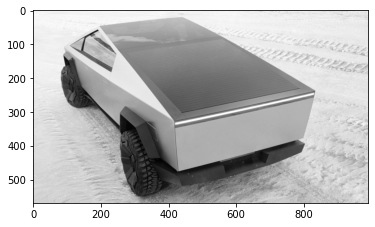

In [6]:
img.shape
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_ = plt.imshow(gray, cmap='gray')

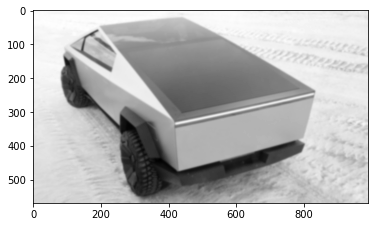

In [7]:
kernel_size = (19, 19)
sigma = 2
blurred = cv2.GaussianBlur(gray, kernel_size, sigma)
#convolves the source image with the specified Gaussian kernel.
_ = plt.imshow(blurred, cmap='gray')

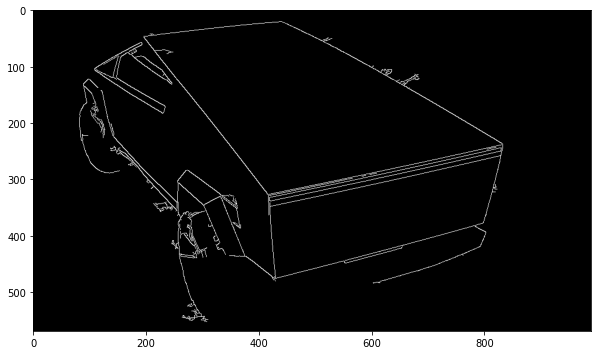

In [8]:
edges = cv2.Canny(gray, 50, 500, apertureSize=3)
plt.figure(figsize=(10, 10))
plt.imshow(edges, cmap='gray')

#cv2.imwrite('edges.png', edges) Save to disk

In [9]:
threshold = 150
distance_resolution = 1 # 1 pixel increments
angular_resolution = math.pi/180.0 * 1 # 1 degree increments
lines = cv2.HoughLines(edges, distance_resolution, angular_resolution, threshold)
# each line is represented by (rho, theta), where rho is a distance and 
#theta is the line's angle (in radians)
# the line uses this formula: rho = x cos theta + y sin theta

lines[:5, 0]

array([[ 407.       ,    1.3613569],
       [ 412.       ,    1.3613569],
       [ 418.       ,    1.3613569],
       [-213.       ,    2.0943952],
       [ 572.       ,    1.3089969]], dtype=float32)

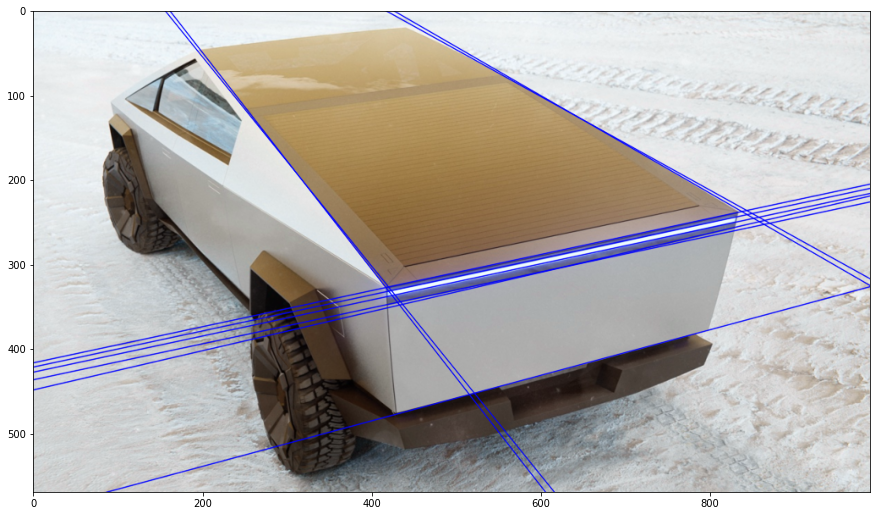

In [11]:
height, width, _ = img.shape
image_output = img.copy()
blue = (0, 0, 255)

def calc_y(x, rho, theta):
    if theta == 0:
        # prevent divide by zero
        return rho
    else:
        return (-math.cos(theta) / math.sin(theta)) * x + (rho / math.sin(theta))

height, width, _ = img.shape

def polar_to_xy(rho, theta):
    x1 = 0
    x2 = width
    y1 = int(calc_y(0, rho, theta))
    y2 = int(calc_y(width, rho, theta))
    return (x1, y1), (x2, y2)

for rho, theta in lines[:,0,]:
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv2.line(image_output, (x1, y1), (x2, y2), blue, 1, cv2.LINE_AA)
    
plt.figure(figsize=(15, 10))
plt.imshow(image_output)


In [12]:
distance_resolution = 2
angular_resolution = math.pi/180.0 / 6

# the maximum possible line length
max_rho = math.sqrt(width**2 + height**2)

# the number of linear steps (+/- max rho)
num_rho = int(2 * max_rho / distance_resolution) - 1
max_rho = num_rho * distance_resolution / 2

# the number of discrete angular steps
num_theta = int(math.pi / angular_resolution)

# we make a blank "accumulator" 2d array
# each point = one line
accumulator = np.zeros((num_rho, num_theta)).astype(np.int32)
accumulator.shape

(1140, 1080)

In [16]:
from tqdm.notebook import tqdm
#Note: if you just do import tqdm without from, it will have error regarding module not being callable
!jupyter nbextension enable --py widgetsnbextension

for x in tqdm(range(0, width), desc='x'):
    for y in range(0, height):
        
        # get edge colour - will be either 0 (black), or 255 (white)
        edge_colour = edges[y, x]
        
        # if there's an edge
        if edge_colour != 0:
            
            # array of each of the discrete values of theta
            # (based on our angular resolution - from 0 to pi radians)
            theta_arr = np.arange(0, math.pi, angular_resolution)

            # solve for the corresponding rho using the line equation
            rho_arr = x * np.cos(theta_arr) + y * np.sin(theta_arr)

            # we then round each of the allowed discrete values of rho 
            # This will give us a locus of points lying approximately on a sinusoidal
            # curve for each edge point (x, y)
            rho_index_arr = np.rint(rho_arr/distance_resolution + num_rho/2).astype(np.int32)
            theta_index_arr = np.rint(theta_arr/angular_resolution).astype(np.int32)
            
            # use some numpy magic to sum matrix coordinates
            acc = np.bincount(rho_index_arr * accumulator.shape[1] + theta_index_arr)
            acc.resize(accumulator.shape)
            
            # increment by one each of the points in our accumulator matrix
            # that make up this sinusoidal curve
            accumulator += acc

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


x:   0%|          | 0/990 [00:00<?, ?it/s]

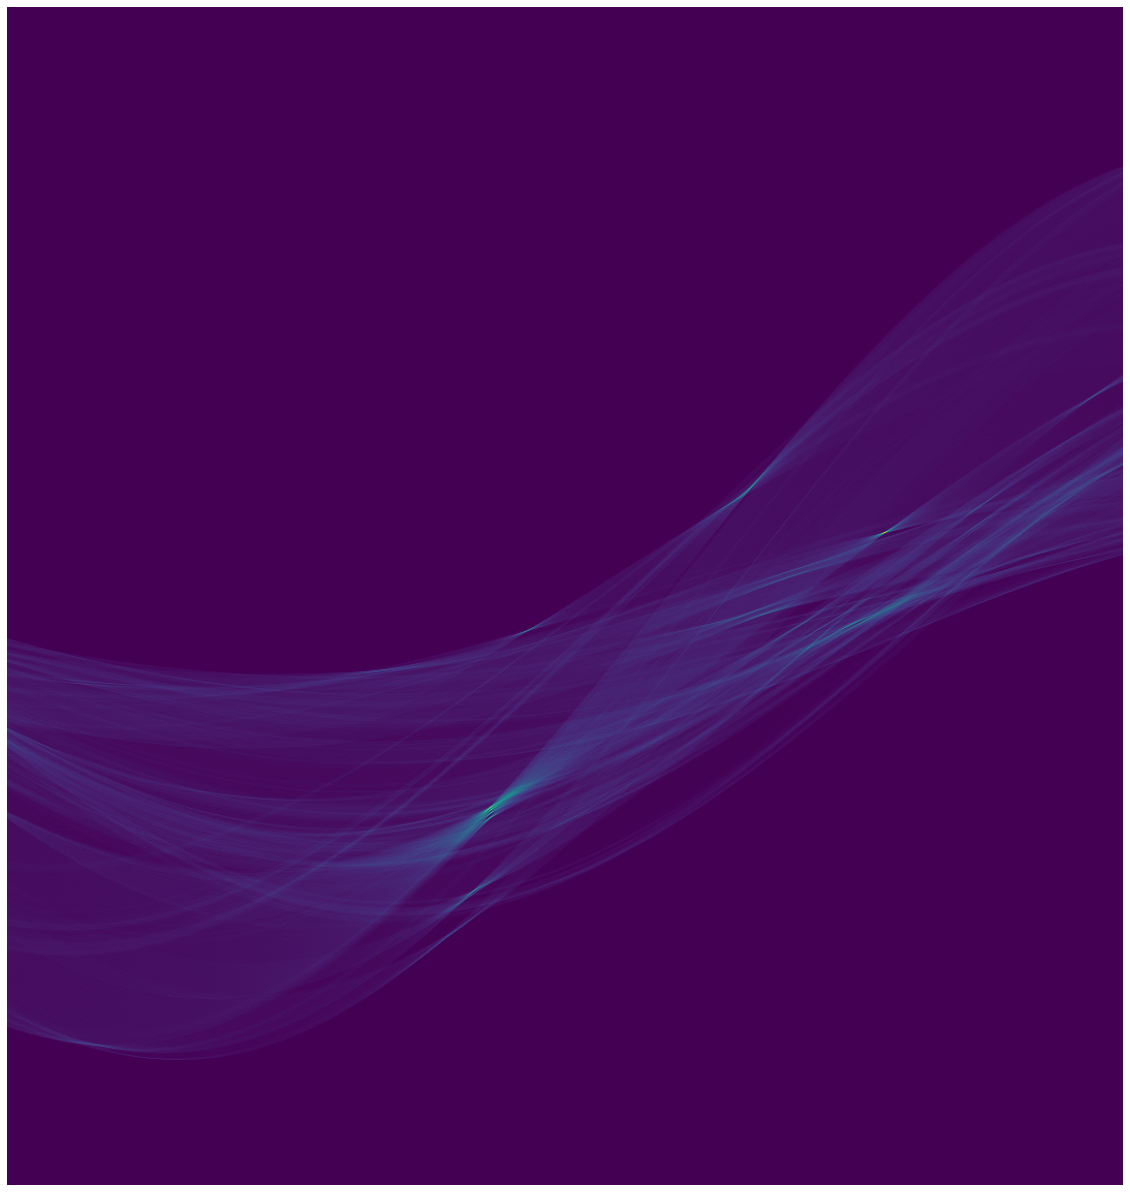

In [17]:
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='viridis')
plt.xlabel('theta')
plt.ylabel('rho')
plt.axis('off')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator.png', bbox_inches=extent, pad_inches=0)

Text(0, 0.5, 'rho')

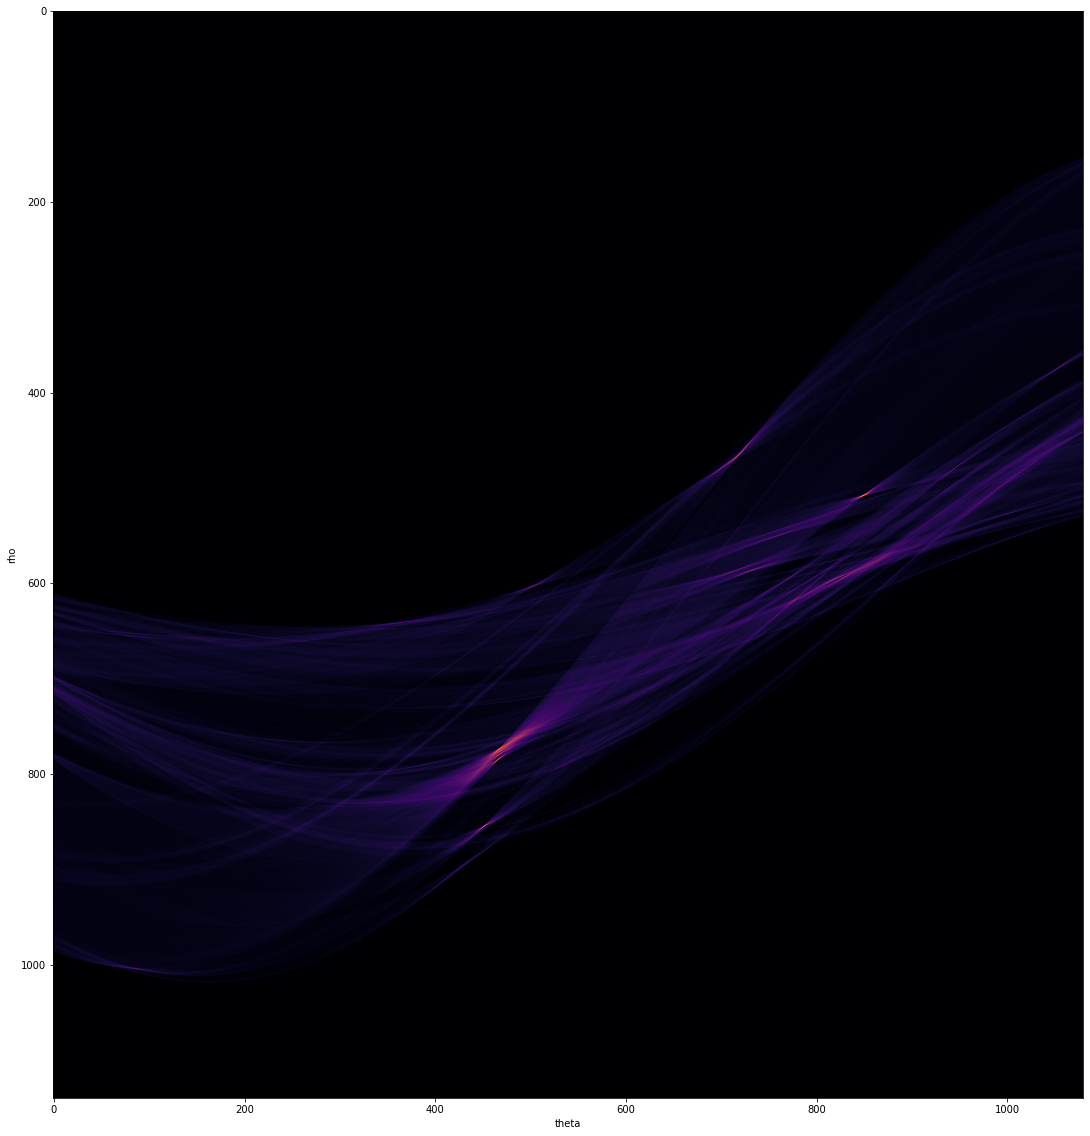

In [18]:
# Try a different colour map
plt.figure(figsize=(20, 20))
plt.imshow(accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')

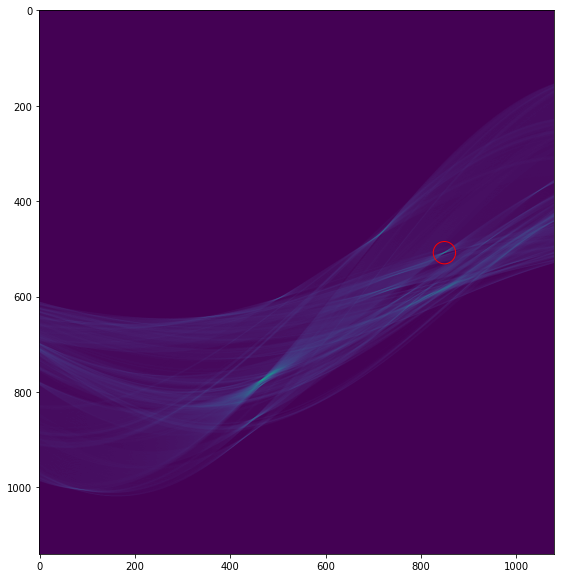

In [19]:
# Find the rho/theta coordinate of the max point
# this will be the strongest line in our image
max_rho_index, max_theta_index = np.unravel_index(accumulator.argmax(axis=None), accumulator.shape)
(max_rho_index, max_theta_index)
# circle the max point
plt.figure(figsize=(10, 10))
plt.imshow(accumulator, cmap='viridis')
_ = plt.scatter(max_theta_index, max_rho_index, 500, color='r', facecolors='none', marker='o')

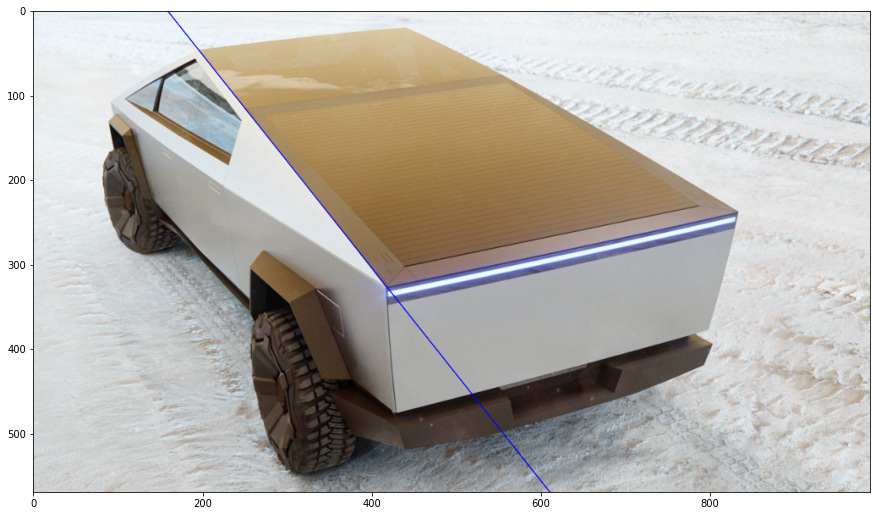

In [20]:
# convert index to actual rho/theta
max_rho_val = (max_rho_index - num_rho/2) * distance_resolution
max_theta_val = max_theta_index * angular_resolution
max_rho_val, max_theta_val
# convert from polar coordinates to x/y coordinates
(x1, y1), (x2, y2) = polar_to_xy(max_rho_val, max_theta_val)
(x1, y1), (x2, y2)
# draw line on image
max_line_img = img.copy()
cv2.line(max_line_img, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)
plt.figure(figsize=(15, 10))
plt.imshow(max_line_img)

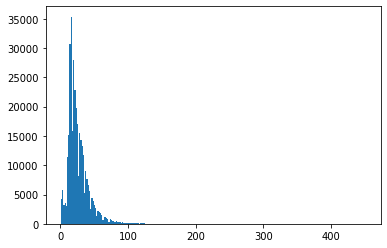

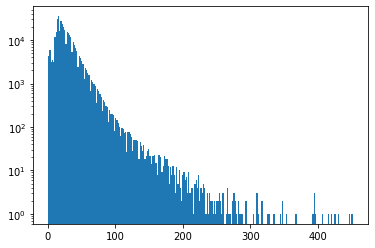

In [21]:
# Plot histogram of accumulator, to see what threshold is appropriate
flat = accumulator.flatten()
plt.figure()
plt.hist(flat[flat > 0], bins=250)
plt.figure()
plt.hist(flat[flat > 0], bins=250, log=True)
None

(600.0, 1000.0)

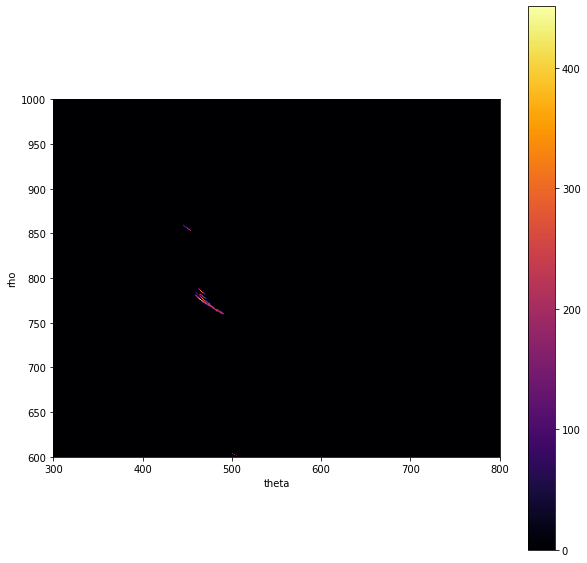

In [22]:
threshold = 200
thresholded_accumulator = accumulator.copy()
thresholded_accumulator[thresholded_accumulator <= threshold ] = 0 # np.nan

# Preview thresholded accumulator 
plt.figure(figsize=(10, 10))
plt.imshow(thresholded_accumulator, cmap='inferno')
plt.xlabel('theta')
plt.ylabel('rho')
plt.colorbar()

# zoom in a bit (manually)
plt.xlim(300, 800)
plt.ylim(600, 1000)

In [24]:
#Trying to detect local peaks
# peaks are separated by at least min_distance
from skimage.feature import peak_local_max

min_distance = 7
coordinates = peak_local_max(thresholded_accumulator, min_distance=min_distance)
coordinates.shape
coordinates[:5,:]


array([[508, 849],
       [776, 468],
       [785, 466],
       [855, 451],
       [464, 720]])

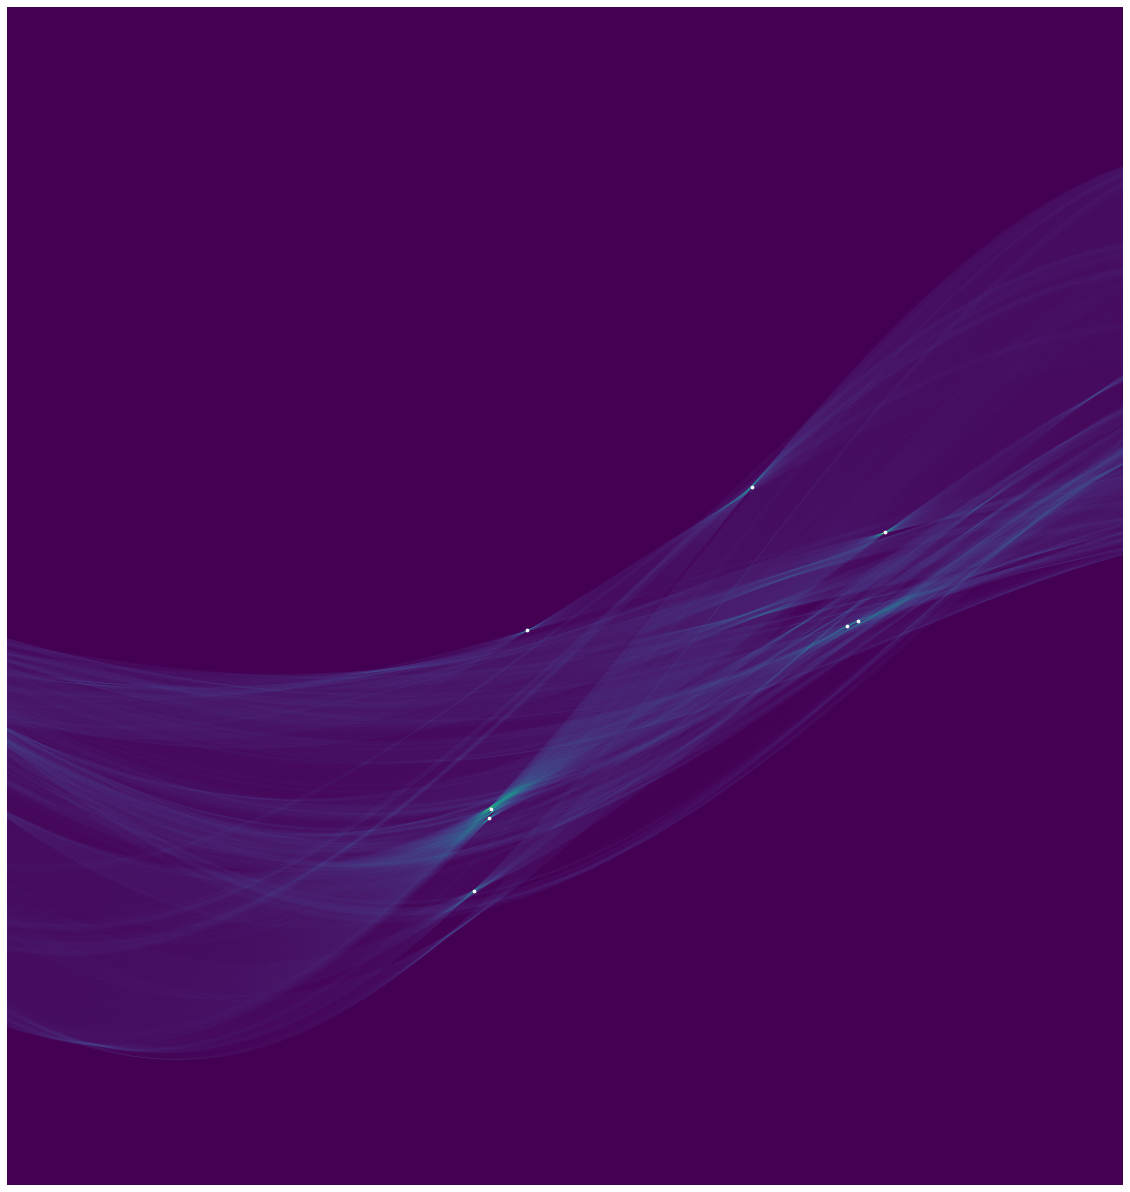

In [25]:
# circle the local peaks / maxima
fig = plt.figure(figsize=(20, 22))
plt.imshow(accumulator, cmap='viridis')
plt.axis('off')
plt.scatter(coordinates[:,1], coordinates[:,0], 30, color='w', marker='.')
extent = fig.gca().get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('accumulator_points.png', bbox_inches=extent, pad_inches=0)

True

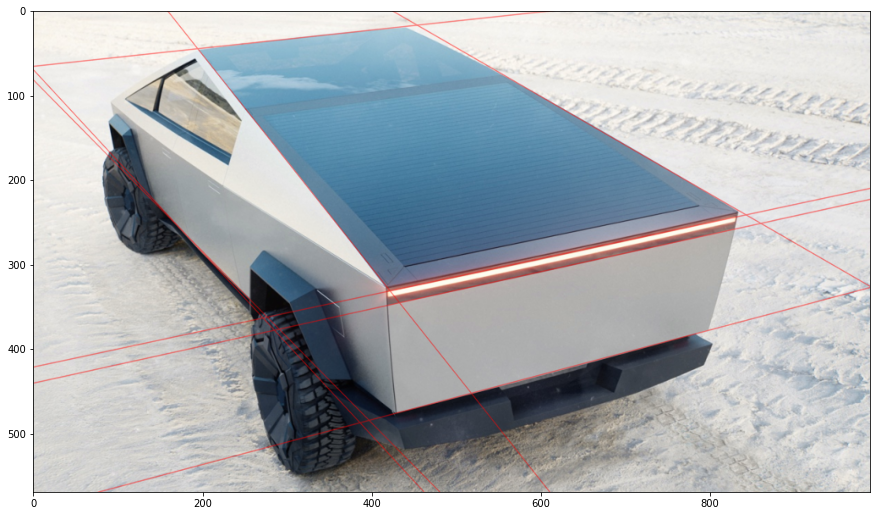

In [26]:
# Now convert all these points back to lines,
# and draw lines on a copy of the image
image_output = img.copy()

red = (0, 0, 255) # using BGR for cv2.imwrite

for rho_index, theta_index in coordinates:
    rho = (rho_index - num_rho/2) * distance_resolution
    theta = theta_index * angular_resolution
#     print((rho_index, theta_index), (rho, theta))
    (x1, y1), (x2, y2) = polar_to_xy(rho, theta)
    cv2.line(image_output, (x1, y1), (x2, y2), red, 1, cv2.LINE_AA)

# 50% "transparency" lines
image_output = cv2.addWeighted(img.copy(), 0.5, image_output, 0.5, 1)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR)) # expects RGB not BGR
cv2.imwrite('output.png', image_output) # write as BGR